# Conspiracy Theory Election Notebook




Exploration of Election Twitter dataset

## Importing Data

In [3]:
import pandas as pd
import numpy as np
import json
import jsonlines
import os
from os import path
from PIL import Image
from tqdm.auto import tqdm as tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import listdir
from os.path import isfile, join
from collections import Counter
from nltk import ngrams
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
import warnings
import time
import botometer
warnings.filterwarnings("ignore")

### Sampling to reduce dataset size

Not required if using preprocessed data

In [4]:
homepath = '../../'
election_path = homepath + 'election_data/'

In [5]:
# Files downloaded from Emily's dataset
months = ['2020-06/','2020-07/','2020-08/','2020-09/']

In [6]:
# List the csv files in the directories
csv_files = []
filepath = election_path + 'election_csvs/'
files = []
files = [f for f in os.listdir(filepath) if not f.startswith('.')]
for month in months:
    csv_files  += [filepath+month + f for f in listdir(filepath+month) if isfile(join(filepath+month, f)) and not f.startswith('.') and f[-3:] == 'csv']
csv_files = sorted(csv_files)
len(csv_files)

1886

In [7]:
# Timestamps of the csvs
csv_timestamps  = []
for i in range(len(csv_files)):
    csv_timestamps.append(pd.Timestamp(csv_files[i][-23:-18]+csv_files[i][-12:-4]))

In [26]:
# Sampling 

dates = []
hours = []
sample_every = 100

print('No. files:', len(csv_timestamps[::sample_every]))
sample_files =  csv_files[::sample_every]

for i in range(len(csv_timestamps[::sample_every])):
    dates.append(csv_timestamps[::sample_every][i].day)
    hours.append(csv_timestamps[::sample_every][i].hour)

No. files: 19


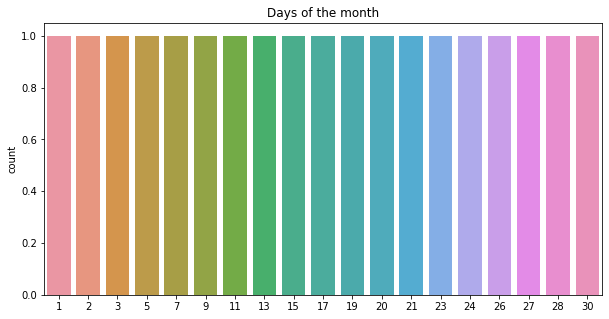

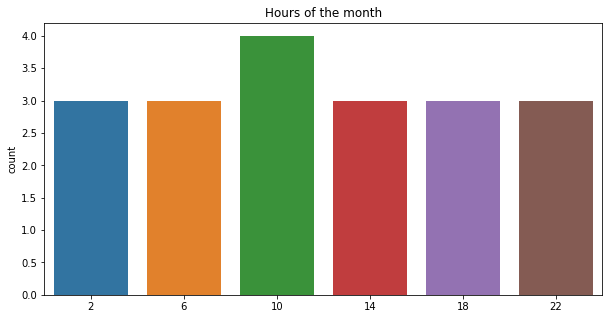

In [27]:
# Make sure the samples have an even number of days in the month and the hours
plt.figure(figsize = (10,5))
plt.title('Days of the month')
sns.countplot(dates)
plt.show()

plt.figure(figsize = (10,5))
plt.title('Hours of the month')
sns.countplot(hours)
plt.show()

In [28]:
# # Get sampled dfs for general corona tweets
control_df = pd.DataFrame()

# Get only conspiracy and url with news chanel related tweets
col_list = ['tweetid', 'userid', 'screen_name', 'date', 'lang', 'location', 'text',
            'tweet_type', 'followers_count','favourites_count', 'verified', 'hashtag', 
            'mentionid','mentionsn','rt_userid','rt_screen','rt_rt_count','rt_fav_count',
            'rt_tweetid','urls_list','account_creation_date']

for i,file in tqdm(enumerate(sample_files)):
#     control_df = control_df.append(pd.read_csv(file,usecols=col_list))
    control_df = control_df.append(pd.read_csv(file))

control_df.shape

(2354746, 63)

In [29]:
for i in control_df.columns: print(i)

tweetid
userid
screen_name
date
lang
location
place_id
place_url
place_type
place_name
place_full_name
place_country_code
place_country
place_bounding_box
text
extended
coord
reply_userid
reply_screen
reply_statusid
tweet_type
friends_count
listed_count
followers_count
favourites_count
statuses_count
verified
hashtag
urls_list
profile_pic_url
profile_banner_url
display_name
date_first_tweet
account_creation_date
rt_urls_list
mentionid
mentionsn
rt_screen
rt_userid
rt_text
rt_hashtag
rt_qtd_count
rt_rt_count
rt_reply_count
rt_fav_count
rt_tweetid
rt_location
qtd_screen
qtd_userid
qtd_text
qtd_hashtag
qtd_qtd_count
qtd_rt_count
qtd_reply_count
qtd_fav_count
qtd_tweetid
qtd_urls_list
qtd_location
sent_vader
token
media_urls
rt_media_urls
q_media_urls


In [30]:
# Get random names from control df

# import random
# len(control_df.screen_name.unique())
# rands = random.choices(control_df.screen_name.unique(), k= 5000)
# rands = [i.lower() for i in rands]
# control_names = pd.DataFrame(rands, columns=['names'])
# control_names.to_csv('Botometer_to_query/control_election_names.csv',index=False)

# Conspiracy theory analysis

In [31]:
def create_cloud(string,exclude = None):
    wordcloud = WordCloud(width=800,height=400,max_font_size=50, max_words=100,
                      collocations=False, background_color="white", stopwords = exclude
                     ).generate(string)

    # Display the generated image:
    plt.figure(figsize = (20,20))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [32]:
# Find hashtags for tweets
def hash_tweets(string,df):
    tweets = df[df.hashtag.str.contains(string)]
    return tweets

In [33]:
# Find text for tweets
def text_tweets(string,df):
    tweets = df[df.text.str.contains(string)]
    return tweets

In [34]:
# Find urls for tweets
def url_tweets(string,df):
    tweets = df[df.urls_list.str.contains(string)]
    return tweets

In [35]:
# Get tweets, create a cloud, get users associated with each url substring
def get_hashtags_tweets(df,hashtag_list,cloud=True,printing=False):
    users = set()
    hash_dict = {}
    hash_df = pd.DataFrame()

    for hashtag in hashtag_list:
        these_hashtags = hash_tweets(hashtag,df)
        hash_df = hash_df.append(these_hashtags)
        hash_dict[hashtag] = these_hashtags.screen_name.unique()
        these_users = list(these_hashtags.screen_name.unique())
        users.update(these_users)
        if cloud:
            related_hashs = ' '.join(these_hashtags.hashtag)
            try:
                create_cloud(related_hashs,exclude = [hashtag])
            except:
                pass
        if printing:
            print('\n%s num tweets: %d' % (hashtag, len(hash_df)))
            print('%s unique users: %d' %(hashtag, len(these_users)))
    
    return list(users), hash_dict, hash_df

In [36]:
# Get tweets, create a cloud, get users associated with each url substring
def get_url_usertweets(df,url_list):
    users = set()
    url_dict = {}
    url_df = pd.DataFrame()

    for url in url_list:
        these_urls = url_tweets(url,df)
        url_df = url_df.append(these_urls)
        url_dict[url] = these_urls.screen_name.unique()
        users.update(list(these_urls.screen_name.unique()))
    
    return list(users), url_dict, url_df

In [37]:
# Get tweets, create a cloud, get users associated with each url substring
def get_text_tweets(df,text_list):
    users = []
    text_dict = {}
    text_df = pd.DataFrame()

    for text in text_list:
        these_keyword = text_tweets(text,df)
        text_df = text_df.append(these_keyword)
        text_dict[text] = these_keyword.screen_name.unique()
        users += list(these_keyword.screen_name.unique())
    
    return users, text_dict, text_df

In [38]:
def unique(list1): 
    x = np.array(list1) 
    return np.unique(x)

In [39]:
""" 
Tweet Columns
       'tweetid', 'userid', 'screen_name', 'date', 'lang', 'location',
       'place_id', 'place_url', 'place_type', 'place_name', 'place_full_name',
       'place_country_code', 'place_country', 'place_bounding_box', 'text',
       'extended', 'coord', 'reply_userid', 'reply_screen', 'reply_statusid',
       'tweet_type', 'friends_count', 'listed_count', 'followers_count',
       'favourites_count', 'statuses_count', 'verified', 'hashtag',
       'urls_list', 'profile_pic_url', 'profile_banner_url', 'display_name',
       'date_first_tweet', 'account_creation_date', 'rt_urls_list',
       'mentionid', 'mentionsn', 'rt_screen', 'rt_userid', 'rt_text',
       'rt_hashtag', 'rt_qtd_count', 'rt_rt_count', 'rt_reply_count',
       'rt_fav_count', 'rt_tweetid', 'qtd_screen', 'qtd_userid', 'qtd_text',
       'qtd_hashtag', 'qtd_qtd_count', 'qtd_rt_count', 'qtd_reply_count',
       'qtd_fav_count', 'qtd_tweetid', 'qtd_urls_list'                         
"""

# rt_screen is who is being retweeted

" \nTweet Columns\n       'tweetid', 'userid', 'screen_name', 'date', 'lang', 'location',\n       'place_id', 'place_url', 'place_type', 'place_name', 'place_full_name',\n       'place_country_code', 'place_country', 'place_bounding_box', 'text',\n       'extended', 'coord', 'reply_userid', 'reply_screen', 'reply_statusid',\n       'tweet_type', 'friends_count', 'listed_count', 'followers_count',\n       'favourites_count', 'statuses_count', 'verified', 'hashtag',\n       'urls_list', 'profile_pic_url', 'profile_banner_url', 'display_name',\n       'date_first_tweet', 'account_creation_date', 'rt_urls_list',\n       'mentionid', 'mentionsn', 'rt_screen', 'rt_userid', 'rt_text',\n       'rt_hashtag', 'rt_qtd_count', 'rt_rt_count', 'rt_reply_count',\n       'rt_fav_count', 'rt_tweetid', 'qtd_screen', 'qtd_userid', 'qtd_text',\n       'qtd_hashtag', 'qtd_qtd_count', 'qtd_rt_count', 'qtd_reply_count',\n       'qtd_fav_count', 'qtd_tweetid', 'qtd_urls_list'                         \n"

In [40]:
# Conspiracy theory hashtags
qanon_keywords = ['qanon',
                  'greatawakening',
                  'wwg1wga',
                  'taketheoath',
                  'digitalsoldier',
                  'qarmy'
                 ]

conspiracy_keywords = ['conspiracy',
                       'falseflag',
                       'deepstate']

# gate_keywords = ['pizzagate',
#                  'obamagate',
#                  'pedogate'
#                  ]

gate_keywords = ['gate'
                 ]

all_keywords = list(set(qanon_keywords+conspiracy_keywords+gate_keywords))

In [41]:
# News url substrings to look for in tweet url lists (Try sampling)

news_sources = ['msnbc',
                'nydailynews',
                'reuters',
                'foxnews',
                'cnn',
                'wsj',
                'huffpost',
                'nyt',
                'dailymail',
                'washingtonpost',
                'theguardian',
                'abcnews',
                'bbc',
                'usatoday',
                'infowars',
                'oann',
                'latimes',
                'cnbc',
                'boston',
                'yahoo',
                'chicagotribune',
                'msn',
                'breitbart'
               ]

### Get tweets from preprocessed csvs

Used once the conspiracy theory tweets have been found and saved

In [133]:
# # Preprocessed csvs with only conspiracy and url tweets
# df1 = pd.read_csv(election_path + 'election_conspiracies_parsed_1.csv')
# df2 = pd.read_csv(election_path + 'election_conspiracies_parsed_2.csv')
# df3 = pd.read_csv(election_path + 'election_conspiracies_parsed_3.csv')

# print(df1.shape)
# print(df2.shape)
# print(df3.shape)
# df = df1.append(df2).append(df3)

In [32]:
df = pd.read_csv(election_path + 'election_conspiracies_and_urls.csv')

In [33]:
df.shape

(2335628, 22)

In [34]:
# df = pd.read_csv(election_path + 'election_just_consp_hashtags.csv')
# df = df.append(pd.read_csv(election_path + 'election_just_news_urls.csv'))
# df.shape

In [35]:
# df.drop_duplicates(inplace = True)
# df.to_csv(election_path + 'election_conspiracies_and_urls.csv', index=False)

In [36]:
# # Separate retweets from non retweets tweets
# orig_df = df[pd.isnull(df['rt_userid'])]
# rt_df = df.dropna(subset=['rt_userid'])

In [37]:
# Use if all df loaded from csv
tweet_df = df
tweet_df = df.dropna(subset=['hashtag'])
df = pd.DataFrame()

# Get only conspiracy and url with news chanel related tweets
col_list = ['tweetid', 'userid', 'screen_name', 'date', 'lang', 'location', 'text',
            'tweet_type', 'followers_count','favourites_count', 'verified', 'hashtag', 
            'mentionid','mentionsn','rt_userid','rt_screen','rt_rt_count','rt_fav_count',
            'rt_tweetid','urls_list','account_creation_date','sent_vader']

clouds = False

qanon_users=set()
conspiracy_users=set()
gate_users=set()

url_dict = {}

tweet_df.reset_index(drop=True,inplace=True)
tweet_df = tweet_df.apply(lambda x: x.astype(str).str.lower())
tweet_df.replace('nan',np.nan,inplace=True)
tweet_df.hashtag = tweet_df.hashtag.str.replace("'", '')

qanon_users_h, qanon_dict_h, qanon_df_h = get_hashtags_tweets(tweet_df,qanon_keywords,cloud=clouds,printing=True)
conspiracy_users_h, conspiracy_dict_h, conspiracy_df_h = get_hashtags_tweets(tweet_df,conspiracy_keywords,cloud=clouds,printing=True)
gate_users_h, gate_dict_h, gate_df_h = get_hashtags_tweets(tweet_df,gate_keywords,cloud=clouds,printing=True)

tweet_df = tweet_df[tweet_df.urls_list!='[]']

qanon_users.update(qanon_users_h)
conspiracy_users.update(conspiracy_users_h)
gate_users.update(gate_users_h)

# Get tweets, create a cloud, get users associated with each news source
url_users, url_dict_temp, news_url_df = get_url_usertweets(tweet_df,news_sources)
for urlkey,urlval in url_dict_temp.items():
    this_set = set(urlval)
    if url_dict.get(urlkey):
        this_set.update(url_dict.get(urlkey))
    url_dict[urlkey]=this_set

df = df.append(qanon_df_h)
df = df.append(conspiracy_df_h)
df = df.append(gate_df_h)

df = df.append(news_url_df)

del tweet_df, news_url_df
gc.collect()


qanon num tweets: 239254
qanon unique users: 74217

greatawakening num tweets: 322838
greatawakening unique users: 31170

wwg1wga num tweets: 682243
wwg1wga unique users: 85334

taketheoath num tweets: 811774
taketheoath unique users: 31644

digitalsoldier num tweets: 871689
digitalsoldier unique users: 23395

qarmy num tweets: 929276
qarmy unique users: 17738

conspiracy num tweets: 8055
conspiracy unique users: 4901

falseflag num tweets: 9181
falseflag unique users: 753

deepstate num tweets: 57820
deepstate unique users: 24110

pizzagate num tweets: 23588
pizzagate unique users: 12454

obamagate num tweets: 265492
obamagate unique users: 84143

pedogate num tweets: 276321
pedogate unique users: 6674


249

In [139]:
print(qanon_df_h.shape)
print(conspiracy_df_h.shape)
print(gate_df_h.shape)
df.shape

(1314168, 21)
(29307, 21)


(1348020, 21)

In [140]:
consp_users = qanon_users
consp_users.update(pizza_users)
consp_name_df = pd.DataFrame(list(consp_users), columns=['names'])
# consp_name_df.to_csv('Botometer_to_query/qanon_pizza_users.csv', index=False)

### Get all tweets from raw tweet files

In [42]:
# Use for processing all tweets from downloaded dataset

# Get only conspiracy and url with news chanel related tweets
col_list = ['tweetid', 'userid', 'screen_name', 'date', 'lang', 'location', 'text',
            'tweet_type', 'followers_count','favourites_count', 'verified', 'hashtag', 
            'mentionid','mentionsn','rt_userid','rt_screen','rt_rt_count','rt_fav_count',
            'rt_tweetid','urls_list','account_creation_date','sent_vader']

df = pd.DataFrame()

clouds=False

qanon_users=set()
conspiracy_users=set()
gate_users=set()

url_dict = {}

for i,file in tqdm(enumerate(sample_files)):

    tweet_df = pd.read_csv(file,usecols=col_list)
    tweet_df.reset_index(drop=True,inplace=True)
    tweet_df = tweet_df.apply(lambda x: x.astype(str).str.lower())
    tweet_df.replace('nan',np.nan,inplace=True)
    tweet_df.hashtag = tweet_df.hashtag.str.replace("'", '')

#     qanon_users_h, qanon_dict_h, qanon_df__h = get_hashtags_tweets(tweet_df,qanon_keywords,cloud=clouds)
#     conspiracy_users_h, conspiracy_dict_h, conspiracy_df__h = get_hashtags_tweets(tweet_df,conspiracy_keywords,cloud=clouds)
    gate_users_h, gate_dict_h, gate_df__h = get_hashtags_tweets(tweet_df,gate_keywords,cloud=clouds)
    
#     qanon_df_h = qanon_df_h.append(qanon_df__h)
#     conspiracy_df_h = conspiracy_df_h.append(conspiracy_df__h)
#     gate_df_h = gate_df_h.append(gate_df__h)
    
#     qanon_users.update(qanon_users_h)
#     conspiracy_users.update(conspiracy_users_h)
#     gate_users.update(gate_users_h)
    
#     tweet_df = tweet_df[tweet_df.urls_list!='[]']

#     Get tweets, create a cloud, get users associated with each news source
#     url_users, url_dict_temp, news_url_df = get_url_usertweets(tweet_df,news_sources)
#     for urlkey,urlval in url_dict_temp.items():
#         this_set = set(urlval)
#         if url_dict.get(urlkey):
#             this_set.update(url_dict.get(urlkey))
#         url_dict[urlkey]=this_set

#     df = df.append(qanon_df__h)
#     df = df.append(conspiracy_df__h)
    df = df.append(gate_df__h)

#     df = df.append(news_url_df)

#     if i % 100 == 0:
#         df.to_csv(election_path + 'election_just_consp_bountygate_1.csv', index=False)
    
    del tweet_df#, news_url_df

    gc.collect()
    
# df.to_csv(election_path + 'election_just_consp_bountygate_1.csv', index=False)

In [170]:
conspiracies_df = pd.DataFrame()
for i in range(1,7):
    conspiracies_df = conspiracies_df.append(pd.read_csv(election_path + 'election_just_consp_hashtags_'+str(i)+'.csv'))
    
len(conspiracies_df)

1259758

In [171]:
conspiracies_df.to_csv(election_path + 'election_just_consp_hashtags.csv',index=False)

In [129]:
# urls_df = pd.DataFrame()
# for i in range(1,7):
#     urls_df = urls_df.append(pd.read_csv(election_path + 'election_just_news_urls_'+str(i)+'.csv'))
    
# len(urls_df)

1523163

In [130]:
# urls_df.to_csv(election_path + 'election_just_news_urls.csv',index=False)

In [132]:
urls_df.shape

(1523163, 22)

In [124]:
df

tweetid               userid      screen_name  \
18656   1274290835388055552   827749589264560128       elvondrake   
22294   1274291922270597121   827749589264560128       elvondrake   
29907   1274294134510100483   827749589264560128       elvondrake   
29748   1274294096991973376  1008517274922176514      danielmull7   
17792   1274290593913376768  1222698410064506880  barbara56840275   
...                     ...                  ...              ...   
130807  1274431538487328768   933089373557592064       kc47059011   
131078  1274431571911720961   873012295475089408   staceybjones11   
131631  1274431634134237187   781722345673220097     test55350426   
131918  1274431666270986240           1964993270     tangredierin   
132316  1274431715143016448            248886049        baratti77   

                                  date lang        location  \
18656   sat jun 20 10:39:44 +0000 2020   en             NaN   
22294   sat jun 20 10:44:04 +0000 2020   en             NaN   
29907   sat jun 20 10:52:51 +0000 2020   en             NaN   
29748   sat jun 20 10:52:42 +0000 2020   en  somewhere, usa   
17792   sat jun 20 10:38:47 +0000 2020   en            here   
...                                ...  ...             ...   
130807  sat jun 20 19:58:51 +0000 2020   en             NaN   
131078  sat jun 20 19:58:59 +0000 2020   en   united states   
131631  sat jun 20 19:59:14 +0000 2020   en    new york, ny   
131918  sat jun 20 19:59:21 +0000 2020   en             usa   
132316  sat jun 20 19:59:33 +0000 2020   en     houston, tx   

                                                     text  \
18656   (trump administration = shameless corruption) ...   
22294   (der fuhrer expands his propaganda machine.)  ...   
29907   (thank you dimwit donnie: soon there will be f...   
29748   @briankarem @realdonaldtrump trump personally ...   
17792   @ketronshawn @gorgood76 @indyspanglish @realdo...   
...                                                   ...   
130807  rt @realdonaldtrump: watch live: trump support...   
131078  rt @realdonaldtrump: watch live: trump support...   
131631  @realdonaldtrump you need to exit twitter and ...   
131918  rt @realdonaldtrump: watch live: trump support...   
132316  rt @realdonaldtrump: watch live: trump support...   

                             tweet_type followers_count favourites_count  ...  \
18656                          original             160             4944  ...   
22294                          original             160             4944  ...   
29907                          original             160             4944  ...   
29748                             reply             170            22818  ...   
17792                             reply               0               62  ...   
...                                 ...             ...              ...  ...   
130807  retweeted_tweet_without_comment            1885            26342  ...   
131078  retweeted_tweet_without_comment            1651            23478  ...   
131631                            reply               3              370  ...   
131918  retweeted_tweet_without_comment            4002            77118  ...   
132316  retweeted_tweet_without_comment             445            18398  ...   

                  hashtag                                          urls_list  \
18656                  []  [{'url': 'https://t.co/lquhiwbvns', 'expanded_...   
22294                  []  [{'url': 'https://t.co/q057enrclp', 'expanded_...   
29907   [realdonaldtrump]  [{'url': 'https://t.co/bm5me12f6y', 'expanded_...   
29748                  []  [{'url': 'https://t.co/jbemb2qf0p', 'expanded_...   
17792                  []  [{'url': 'https://t.co/t6bhmrrbxw', 'expanded_...   
...                   ...                                                ...   
130807                 []  [{'url': 'https://t.co/0nxmjzvqdt', 'expanded_...   
131078                 []  [{'url': 'https://t.co/0nxmjzvqdt', 'expanded_...   
131631  

In [50]:
# df.to_csv(election_path + 'election_conspiracies_parsed.csv', index=False)

In [52]:
print(df.shape)

(147, 21)


## Conspiracy theory wordclouds

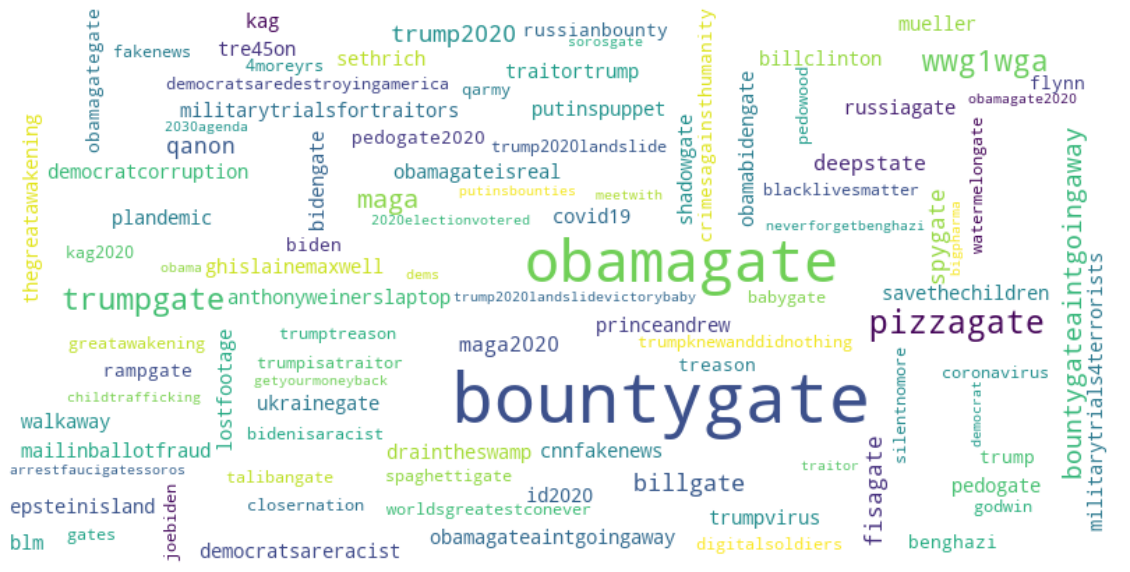

In [43]:
# Get users associated with conspiracy theories and plot wordclouds for related hashtags

clouds=True
# conspiracy_users_h, conspiracy_dict_h, consps_df_h = get_hashtags_tweets(df.dropna(subset=['hashtag']),keywords,cloud=clouds)
# qanon_users_h, qanon_dict_h, qanon_df_h = get_hashtags_tweets(df.dropna(subset=['hashtag']),qanon_keywords,cloud=clouds)
gate_users_h, gate_dict_h, gate_df_h = get_hashtags_tweets(df.dropna(subset=['hashtag']),gate_keywords,cloud=clouds)
# conspiracy_users_h, conspiracy_dict_h, conspiracy_df_h = get_hashtags_tweets(df.dropna(subset=['hashtag']),conspiracy_keywords,cloud=clouds)

In [32]:
all_consp_hashtags_df = pd.concat([qanon_df_h],axis=0)
all_consp_hashtags_df.drop_duplicates(inplace=True)

In [33]:
print('Unique qanon conspiracy tweeters:      ',len(list(set(qanon_users_h))))
print('Unique pizza conspiracy tweeters:      ',len(list(set(pizza_users_h))))

Unique qanon conspiracy tweeters:       119096
Unique pizza conspiracy tweeters:       12454


## Conspiracy keywords in tweet text

Looking at the tweet text instead of hashtags

In [49]:
conspiracy_users, conspiracy_dict, consps_df = get_text_tweets(df,keywords)
qanon_users, qanon_dict, qanon_df = get_text_tweets(df,qanon_keywords)

In [50]:
all_consp_text_df = pd.concat([qanon_df],axis=0)
all_consp_text_df.drop_duplicates(inplace=True)

In [48]:
print('Unique conspiracy tweeters:            ', len(list(set(conspiracy_users))))
print('Unique qanon conspiracy tweeters:      ', len(list(set(qanon_users))))

Unique conspiracy tweeters:             0
Unique qanon conspiracy tweeters:       2556


## News urls and conspiracies

In [104]:
# Urls and number of users
url_keys = url_dict.keys()
url_tots = [len(i) for i in url_dict.values()]

In [105]:
# All tweeters who tweet using conspiracy theory hashtags
all_consp_users = list(set(list(qanon_users)))
len(all_consp_users)

0

In [106]:
# General (non conspiracy) tweeters who use urls from each sources
url_general_users = {}
for key,value in url_dict.items():
    url_general_users[key] = list(set(url_dict[key]).difference(set(all_consp_users)))
    
# Number of general (non conspiracy) tweeters who use urls from each sources
num_url_general = {}
for key,value in url_dict.items():
    num_url_general[key] = len((set(url_dict[key]).difference(set(all_consp_users))))
    
# Number of tweeters who use urls from each sources who tweet conspiracy theories
num_url_consp = {}
for key,value in url_dict.items():
    num_url_consp[key] = len((set(url_dict[key]).intersection(set(all_consp_users))))

# Tweeters who use specific news urls
url_consp_users = {}
for key,value in url_dict.items():
    url_consp_users[key] = set(url_dict[key]).intersection(set(all_consp_users))

In [107]:
url_consp_values = list(num_url_consp.values())
url_props = [vals/tots for vals,tots in zip(url_consp_values,url_tots)]

In [108]:
plt.figure(figsize=(10,5))
plt.title('Proportion of users using conspiracy theory keywords and news urls',size=15)
plt.bar(url_keys,url_props)
plt.xticks(rotation=60,fontsize=13)
plt.show()

In [57]:
# Heatmap matrix for each news website as proportion on users who also link to specific news sites
user_consp_dict = {'qanon':qanon_users,'pizza':pizza_users}
# user_consp_dict = {'qanon':qanon_users}

heatmap_matrix = np.zeros((len(url_dict),len(user_consp_dict)))

for i,(urlkey,urlval) in enumerate(url_dict.items()):
    for j,(userkey,userval) in enumerate(user_consp_dict.items()):
        heatmap_matrix[i,j] = len((set(urlval).intersection(set(userval))))/(len(userval)*len(urlval))*100*100

In [58]:
num_user_keys = [consp + '\n' + str(len(user_consp_dict[consp])) + ' users' for consp in user_consp_dict.keys()]

In [59]:
plt.figure(figsize=(10,8))
sns.heatmap(heatmap_matrix, xticklabels=num_user_keys, yticklabels=news_sources,vmin=0)
plt.title('Proportion of users who also link to news websites\n',fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(rotation=20,fontsize=13)
plt.show()

ValueError: zero-size array to reduction operation fmax which has no identity

<Figure size 720x576 with 0 Axes>

### Drill down on bots

In [224]:
# general_botscores = 0

In [120]:
# Include non conspiracy theory users
user_consp_dict = {'qanon':qanon_users}
num_user_keys = [consp + '\n' + str(len(user_consp_dict[consp])) + ' users' for consp in user_consp_dict.keys()]

In [226]:
heatmap_matrix_bots = np.zeros((len(url_dict),len(user_consp_dict)))

for i,(urlkey,urlval) in enumerate(url_dict.items()):
    for j,(userkey,userval) in enumerate(user_consp_dict.items()):
        
        users = list(set(urlval).intersection(set(userval)))
        score_list = []
        for user in users:
            if all_botdict_en.get(user):
                score_list.append(all_botdict_en.get(user))
        if len(score_list) > 10:
            heatmap_matrix_bots[i,j] = sum(score_list)/len(score_list)
        else:
            heatmap_matrix_bots[i,j] = np.mean(list(all_botdict_en.values()))
        

In [227]:
plt.figure(figsize=(10,8))
plt.title('Average botscore heatmap\n',fontsize=15)
sns.heatmap(heatmap_matrix_bots, xticklabels=num_user_keys, yticklabels=news_sources,vmax=0.4,vmin=0.2)
plt.yticks(fontsize=13)
plt.xticks(rotation=20,fontsize=13)
plt.show()

### Frequency plot of urls
General compared to conspiracy dataset

In [129]:
# Gets a dictionary of number of times urls are used above a threshold value
def get_url_counts(df,num_urls):
    url_df = df[df.urls_list != '[]'].reset_index()
    url_freq = [] 
    for i, row in url_df.iterrows():
        for url in ast.literal_eval(row.urls_list):
            url_freq.append(url['display_url'].split('/')[0])
            
    url_counts = Counter(url_freq)
    sorted_urls = {k: v for k, v in sorted(url_counts.items(), key=lambda item: item[1],reverse=True)[:num_urls]}
    print(sorted_urls)
    return sorted_urls

In [130]:
sorted_control_urls = get_url_counts(tot_df,30)
# sorted_control_urls = get_url_counts(control_df,30)
sorted_consp_urls = get_url_counts(df,30)
# sorted_consp_urls = get_url_counts(df,30)

{'twitter.com': 953012, 'youtu.be': 95680, 'pscp.tv': 46548, 'foxnews.com': 39465, 'youtube.com': 38644, 'breitbart.com': 37547, 'iwillvote.com': 33101, 'nytimes.com': 28075, 'cbsnews.com': 15376, 'cnn.com': 15074, 'facebook.com': 14900, 'google.com': 14338, 'washingtonpost.com': 13791, 'bit.ly': 13247, 'mobile.twitter.com': 9037, 'apple.news': 7654, 'joebiden.com': 7508, 'rawstory.com': 7253, 'businessinsider.com': 7047, 'm.youtube.com': 6753, 'theguardian.com': 6708, 'nbcnews.com': 6348, 'forbes.com': 6174, 'thehill.com': 5966, 'theconservativetreehouse.com': 5059, 'washingtontimes.com': 4981, 'thegatewaypundit.com': 4795, 'politico.com': 4792, 'apnews.com': 4379, 'thedcpatriot.com': 4210}
{'breitbart.com': 270409, 'cnn.com': 160695, 'foxnews.com': 158699, 'washingtonpost.com': 148602, 'nytimes.com': 121141, 'twitter.com': 114972, 'theguardian.com': 40759, 'google.com': 40003, 'msnbc.com': 37485, 'usatoday.com': 31519, 'cnbc.com': 30010, 'huffpost.com': 29998, 'wsj.com': 24698, 'news

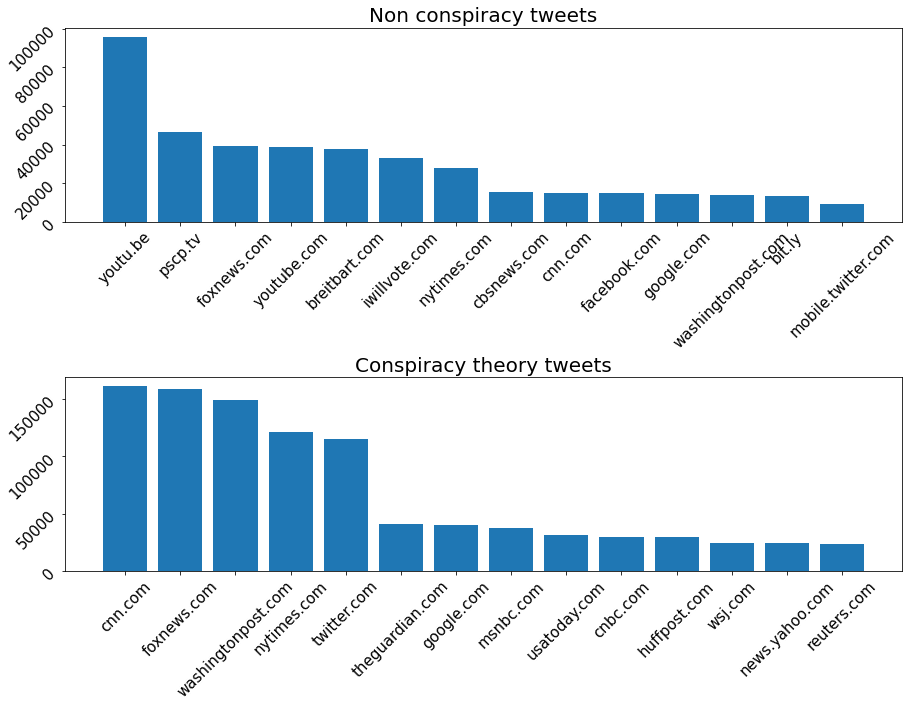

In [123]:
fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].bar(list(sorted_control_urls.keys())[1:15], list(sorted_control_urls.values())[1:15])
ax[0].set_title('Non conspiracy tweets',fontsize=20)
ax[1].bar(list(sorted_consp_urls.keys())[1:15], list(sorted_consp_urls.values())[1:15])
ax[1].set_title('Conspiracy theory tweets',fontsize=20)
ax[0].tick_params(labelrotation=45,labelsize=15)
ax[1].tick_params(labelrotation=45,labelsize=15)
plt.subplots_adjust(hspace = 0.8)
plt.show()

### Temporal analysis

In [60]:
# Maps tweet df date record to pd.Timestamp
def get_date(x):
    date_parts = x.split(' ')
    date = '-'.join([date_parts[1]] + [date_parts[2]] + [date_parts[5]])
    return pd.Timestamp(date)

In [61]:
# # Maps tweet df date and hour record to pd.Timestamp
def get_date_hour(x):
    date_parts = x.split(' ')
    if len(date_parts) < 5:
        return pd.Timestamp('00:00:00')
    date = '-'.join([date_parts[1]] + [date_parts[2]] + [date_parts[5]]) 
    date = pd.Timestamp(date) + pd.Timedelta(hours = int(date_parts[3][0:2]))
    return date

# dates_df = df.date.apply(get_date_hour)

In [62]:
# Create placeholder df for dates
df.date = df.date.apply(get_date)
date_df = pd.DataFrame(columns=list(user_consp_dict.keys()),index=pd.date_range(start=df.date.min(),end=df.date.max()))
date_df.fillna(0,inplace=True)

In [63]:
for consp_df, consp_name in zip([qanon_df_h, pizza_df_h],list(user_consp_dict.keys())):
    dates = consp_df.date.apply(get_date)
    for date in dates.values:
        date_df.loc[date,consp_name] += 1

date_df.describe()

qanon        pizza
count      79.000000    79.000000
mean    16635.037975   370.974684
std     22331.904504   213.597511
min      4082.000000    56.000000
25%      6294.000000   204.000000
50%      9133.000000   355.000000
75%     16990.000000   514.000000
max    173555.000000  1148.000000

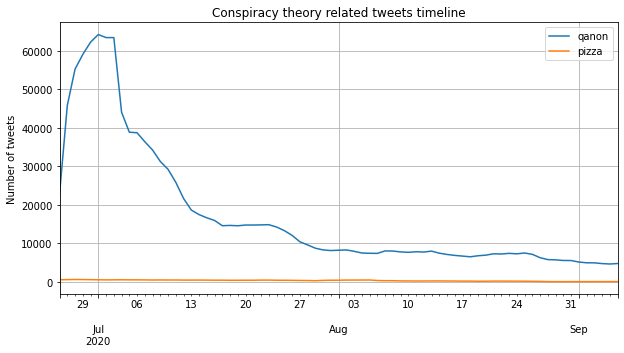

In [64]:
# Smoothed volume of consp hashtags over time
rolling_mean = date_df.rolling(7).mean().dropna()
rolling_mean.plot(y=date_df.columns,use_index=True,figsize=(10,5),fontsize=10)
plt.ylabel('Number of tweets')
plt.title('Conspiracy theory related tweets timeline')
plt.grid()

# Bot analysis

## Get user handles for botometer

Getting screen names to query using Botometer

In [38]:
account_totals = df[['userid','screen_name']].groupby(['userid','screen_name']).size()
account_totals.sort_values(ascending=False)

KeyboardInterrupt: 

In [131]:
account_totals = account_totals.sort_values(ascending=False)

/Users/jaimin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [118]:
url_props = [vals/tots for vals,tots in zip(url_consp_values,url_tots)]

## Load botscore queries

In [200]:
# Get botometer scores for a list
def botometer_query(counter, handles, csv_name):
    rapidapi_key = "6ac8fe69aamshcc30411e7824b49p12a1cajsnc2267278951c"
    twitter_app_auth = {
        'consumer_key':'MmWATyoHu9GdouoNuZNuzzWbi',
        'consumer_secret': 'iYZRcgnKzBZ5GlzBe4olGXBtBT8t0p6K99JeUIeKvPIqBLQk9l',
        'access_token': '1239432784319406080-vuGIvDzEWj6j6EL57427FHnDTipljz',
        'access_token_secret': 'ISafXRzVjGSQc46mjNtMgMXZl3ry9wDmMHiHRVzsMlX60',
      }

    botometer_api_url = 'https://botometer-pro.p.rapidapi.com'
    bom = botometer.Botometer(botometer_api_url=botometer_api_url,
                              wait_on_ratelimit=True,
                              rapidapi_key=rapidapi_key,
                              **twitter_app_auth)

    daily_lim = 0
    this_acc = ''
    start_day = time.time()

    while counter < len(handles):
        try:
            for screen_name, result in bom.check_accounts_in(handles[counter:]):

                this_acc = screen_name
                with open('Botometer_results/' + csv_name + '.csv', 'a+') as file:
                    file.write('%s\n' % json.dumps(result))
                counter += 1
                daily_lim += 1

                if daily_lim >= 35000:
                    print('Reaced daily max')
                    now = time.time()
                    sleep_secs = 24 *60**2 - (now-start_day)

                    if sleep_secs > 0:
                        time.sleep(sleep_secs)

                    daily_lim = 0
                    start_day = time.time()

        except:
            print('\nSleeping on: ', str(counter),'  ' + this_acc)
            time.sleep(5)

In [35]:
# Returns a list of jsons of each uesr
def read_bot_csv(csv_name):
    file = open(csv_name)
    return file.readlines()

In [36]:
def get_antivax_botscores(df):
    cols = ['screen_name', 'english_botscore']
    user_scores = pd.DataFrame(columns = cols)
    for i in range(len(df)):
        botjson = json.loads(df.iloc[i].json)
        if botjson.get('user').get('user_data'):
            user_scores = user_scores.append(pd.DataFrame({'screen_name':[botjson['user']['user_data']['screen_name']].lower(), 
                                     'english_botscore':[botjson['cap']['english']]}))
        else:
            user_scores = user_scores.append(pd.DataFrame({'screen_name':[botjson['user']['screen_name']].lower(), 
                                     'english_botscore':[botjson['cap']['english']]}))
    user_scores.reset_index(inplace=True,drop=True)
    return user_scores

In [214]:
# Get dictionary of botscores from list of botometer json
def users_dict(json_list):
    bot_dict = {}
    for user in json_list:
        this_user = json.loads(user)
        if this_user.get('user'):
            if this_user.get('user').get('user_data'):
                bot_dict[this_user['user']['user_data']['screen_name'].lower()] = this_user['display_scores']['english']['overall']
            else:
                bot_dict[this_user['user']['screen_name'].lower()] = this_user['display_scores']['english']
    return bot_dict

In [38]:
botfile_path = 'Botometer_results/election/'
bot_consp_df = pd.read_csv(botfile_path + 'qanon_pizza_users.csv')
bot_consp_df.dropna(inplace=True)
print(bot_consp_df.shape)

bot_general_df = pd.read_csv(botfile_path + 'control_election_users.csv')
bot_general_df.dropna(inplace=True)
print(bot_general_df.shape)

(1216, 33)
(894, 33)


In [39]:
botscore_files = [botfile_path + i for i in os.listdir(botfile_path) if i[-3:] == 'csv']
print(botscore_files)
all_botscores = []
all_botdict_en = {}
for botfile in botscore_files:
#     if botfile.startswith('Botometer_results/antivax_results_jsons'):
#         continue
#     elif botfile.startswith('Botometer_results/antivax'):
#         these_botscores = read_bot_csv(botfile)

    these_botscores = read_bot_csv(botfile)
    all_botdict_en.update(users_dict(these_botscores))
    all_botscores += these_botscores

['Botometer_results/election/qanon_pizza_users.csv', 'Botometer_results/election/control_election_users.csv']


In [40]:
print('Number of botscores:',len(all_botscores))
print('Number of botscores:',len(all_botdict_en))

Number of botscores: 2355
Number of botscores: 2110


In [41]:
control_bot_files = [i for i in botscore_files if 'control' in i]
control_botscores = {}

for file in control_bot_files:
    these_scores = read_bot_csv(file)
    control_botscores.update(users_dict(these_scores))
len(control_botscores)

893

In [42]:
consp_bot_files = [i for i in botscore_files if 'control' not in i]
consp_botscores = {}

for file in consp_bot_files:
    these_scores = read_bot_csv(file)
    consp_botscores.update(users_dict(these_scores))

In [43]:
len(consp_botscores)

1217

In [44]:
print('Non conspiracy avg botscore:',sum(control_botscores.values())/ len(control_botscores))
print('Conspiracy avg botscore:',sum(consp_botscores.values())/ len(consp_botscores))

Non conspiracy avg botscore: 0.6101071894340465
Conspiracy avg botscore: 0.7377033377697653


In [45]:
# For url users for baseline comparison
url_bot_files = ['Botometer_results/botometer_general_06_03_unfinished.csv',
                  'Botometer_results/botometer_general_url - Copy.csv',
                  'Botometer_results/botometer_general_url_2 - Copy.csv',
                  'Botometer_results/url_general_bot_queries.csv',
                ]

url_bot_files = [
                  'Botometer_results/botometer_general_url - Copy.csv',
                  'Botometer_results/botometer_general_url_2 - Copy.csv',
                  'Botometer_results/url_general_bot_queries.csv',
                ]

url_botscores = {}

for file in url_bot_files:
    these_scores = read_bot_csv(file)
    url_botscores.update(users_dict(these_scores))

In [47]:
# # # Find Conspiracy theory users
# rt_scored_users = list(rt_df[rt_df['screen_name'].isin(set(all_botdict_en.keys()))].screen_name.unique())
# orig_scored_users = list(orig_df[orig_df['screen_name'].isin(set(all_botdict_en.keys()))].screen_name.unique())

In [202]:
# Get lists of scores
rt_scores = []
orig_scores = []
for name in rt_scored_users:
    rt_scores.append(all_botdict_en[name])
for name in orig_scored_users:
    orig_scores.append(all_botdict_en[name])

## Botscore Results

In [48]:
print(sum(rt_scores)/len(rt_scores))
print(sum(orig_scores)/len(orig_scores))

NameError: name 'rt_scores' is not defined

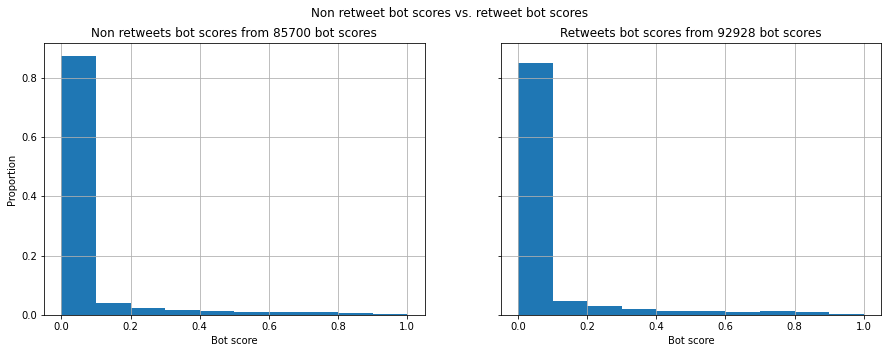

In [204]:
# Bot scores
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
fig.suptitle('Non retweet bot scores vs. retweet bot scores')
ax[0].set_ylabel('Proportion')
ax[0].set_xlabel('Bot score')

ax[0].hist(orig_scores, weights=np.ones(len(orig_scores))/len(orig_scores))
ax[0].set_title('Non retweets bot scores from %d bot scores' % len(orig_scores))
ax[0].grid()

ax[1].set_xlabel('Bot score')
ax[1].hist(rt_scores, weights=np.ones(len(rt_scores))/len(rt_scores))
ax[1].set_title('Retweets bot scores from %d bot scores' % len(rt_scores))
ax[1].grid()
plt.show()

In [205]:
# Comparing botscores for conspiracy theories vs non conspiracy theoies
botvals_general = list(general_botscores.values())
botvals_consp = list(consp_botscores.values())

In [206]:
print('General',sum(botvals_general)/len(botvals_general))
print('Conspiracy',sum(botvals_consp)/len(botvals_consp))

General 0.053641498434632444
Conspiracy 0.06980268171802326


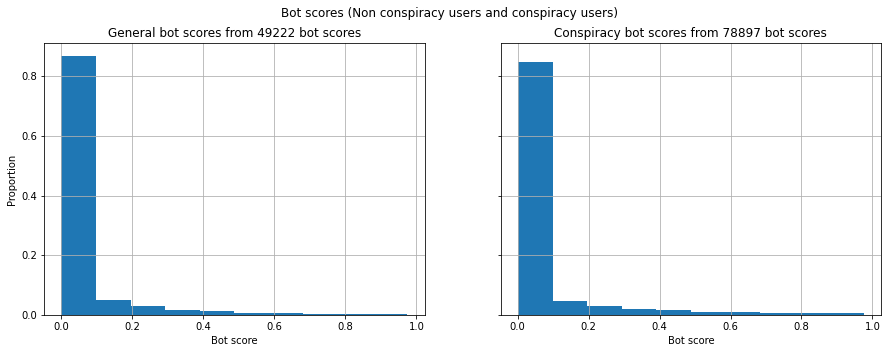

In [207]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
fig.suptitle('Bot scores (Non conspiracy users and conspiracy users)')

ax[0].set_ylabel('Proportion')
ax[0].set_xlabel('Bot score')
ax[0].hist(botvals_general, weights=np.ones(len(botvals_general)) / len(botvals_general))
ax[0].set_title('General bot scores from %d bot scores' % len(botvals_general))
ax[0].grid()

ax[1].set_xlabel('Bot score')
ax[1].hist(botvals_consp, weights=np.ones(len(botvals_consp)) / len(botvals_consp))
ax[1].set_title('Conspiracy bot scores from %d bot scores' % len(botvals_consp))
ax[1].grid()
plt.show()

In [208]:
non_consp_users = set(list(general_botscores.keys()))

In [209]:
# Get botscores for each conspiracy theory
all_botdict_en_china = {}
all_botdict_en_bill = {}
all_botdict_en_qanon = {}
all_botdict_en_hosp = {}
all_botdict_en_fiveg = {}
all_botdict_en_antivax = {}
all_botdict_en_non_consp = {}

# all_botuser_set = set(all_botdict_en.keys())
for screen_name in all_botdict_en.keys():
    if screen_name in china_users:
        all_botdict_en_china[screen_name] = all_botdict_en[screen_name]
    if screen_name in bill_users:
        all_botdict_en_bill[screen_name] = all_botdict_en[screen_name]
    if screen_name in qanon_users:
        all_botdict_en_qanon[screen_name] = all_botdict_en[screen_name]
    if screen_name in hosp_users:
        all_botdict_en_hosp[screen_name] = all_botdict_en[screen_name]
    if screen_name in fiveg_users:
        all_botdict_en_fiveg[screen_name] = all_botdict_en[screen_name]
    if screen_name in antivax_users:
        all_botdict_en_antivax[screen_name] = all_botdict_en[screen_name]
    if screen_name in non_consp_users:
        all_botdict_en_non_consp[screen_name] = all_botdict_en[screen_name]
    
print(len(all_botdict_en_china))
print(len(all_botdict_en_bill))
print(len(all_botdict_en_qanon))
print(len(all_botdict_en_hosp))
print(len(all_botdict_en_fiveg))
print(len(all_botdict_en_antivax))
print(len(all_botdict_en_non_consp))

33356
6748
25125
3233
911
2441
49222


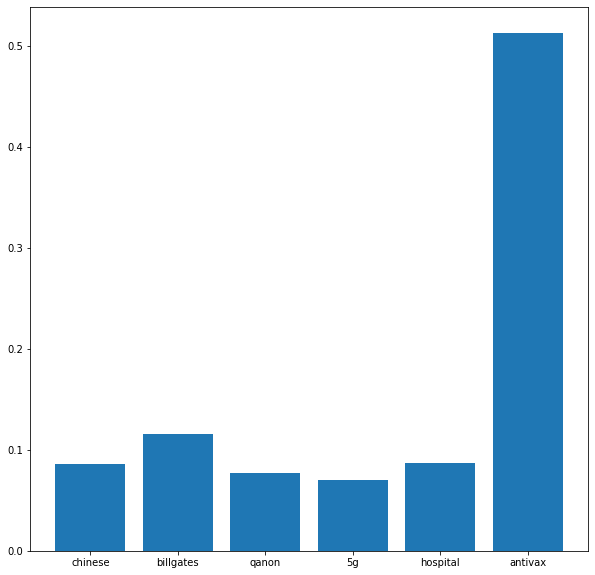

In [211]:
# Average botscore for each group of conspiracy theory users
fig = plt.figure(figsize = (10,10))

avg_botscores= [sum(list(all_botdict_en_china.values()))/len(all_botdict_en_china.values()),
                sum(list(all_botdict_en_bill.values()))/len(all_botdict_en_bill.values()),
                sum(list(all_botdict_en_qanon.values()))/len(all_botdict_en_qanon.values()),
                sum(list(all_botdict_en_hosp.values()))/len(all_botdict_en_hosp.values()),
                sum(list(all_botdict_en_fiveg.values()))/len(all_botdict_en_fiveg.values()),
                sum(list(all_botdict_en_antivax.values()))/len(all_botdict_en_antivax.values())]
#                 sum(list(all_botdict_en_non_consp.values()))/len(all_botdict_en_non_consp.values())]

plt.bar(list(user_consp_dict.keys())[1:],avg_botscores)

plt.show()

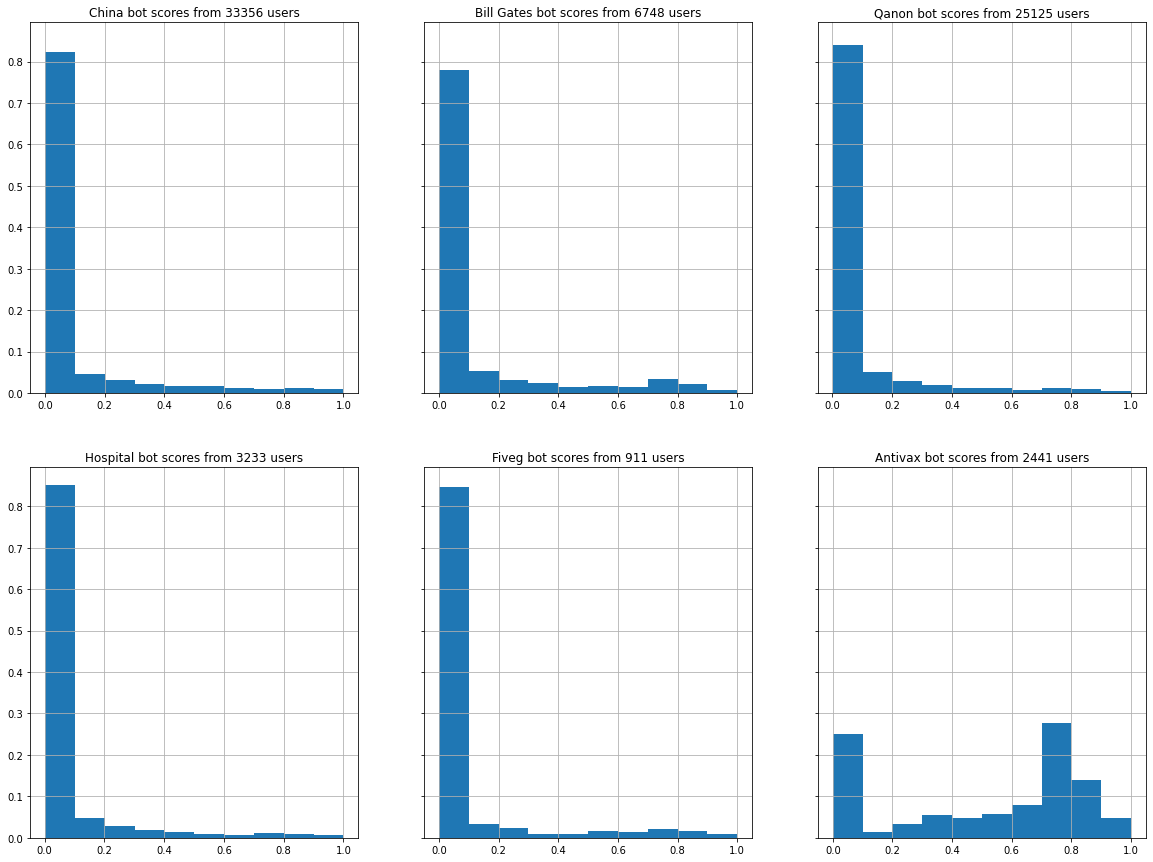

In [212]:
fig, ax = plt.subplots(2,3,figsize=(20,15) ,sharey=True)

ax[0,0].hist(all_botdict_en_china.values(), weights=np.ones(len(all_botdict_en_china)) / len(all_botdict_en_china))
ax[0,0].set_title('China bot scores from %d users' % len(all_botdict_en_china))
ax[0,0].grid()

ax[0,1].hist(all_botdict_en_bill.values(), weights=np.ones(len(all_botdict_en_bill)) / len(all_botdict_en_bill))
ax[0,1].set_title('Bill Gates bot scores from %d users' % len(all_botdict_en_bill))
ax[0,1].grid()

ax[0,2].hist(all_botdict_en_qanon.values(), weights=np.ones(len(all_botdict_en_qanon)) / len(all_botdict_en_qanon))
ax[0,2].set_title('Qanon bot scores from %d users' % len(all_botdict_en_qanon))
ax[0,2].grid()

ax[1,0].hist(all_botdict_en_hosp.values(), weights=np.ones(len(all_botdict_en_hosp)) / len(all_botdict_en_hosp))
ax[1,0].set_title('Hospital bot scores from %d users' % len(all_botdict_en_hosp))
ax[1,0].grid()

ax[1,1].hist(all_botdict_en_fiveg.values(), weights=np.ones(len(all_botdict_en_fiveg)) / len(all_botdict_en_fiveg))
ax[1,1].set_title('Fiveg bot scores from %d users' % len(all_botdict_en_fiveg))
ax[1,1].grid()

ax[1,2].hist(all_botdict_en_antivax.values(), weights=np.ones(len(all_botdict_en_antivax)) / len(all_botdict_en_antivax))
ax[1,2].set_title('Antivax bot scores from %d users' % len(all_botdict_en_antivax))
ax[1,2].grid()

plt.show()

# Find significant users

## Original Tweets

In [201]:
# Only include original tweets
all_df = orig_df[orig_df.tweet_type == 'original']
all_df.dropna(subset=['hashtag'],inplace=True)
all_df[['followers_count','favourites_count']] = all_df[['followers_count','favourites_count']].astype('float')

/Users/jaimin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [202]:
bill_df = all_df[all_df['screen_name'].isin(bill_users)]
fiveg_df = all_df[all_df['screen_name'].isin(fiveg_users)]
china_df = all_df[all_df['screen_name'].isin(china_users)]
hosp_df = all_df[all_df['screen_name'].isin(hosp_users)]

### By follower count

In [203]:
print(bill_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
bill_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['dalenekurtis' 'jamierodr14' 'libertytarian' 'no_democrats' 'kidkool4u'
 'hickorymtnman' 'bamafanaticfan1' 'sherry25793049' 'tmzedg'
 'eavesdropann' 'christinepolon1' 'stephphilip8' 'notunderdog'
 'jpharley3000' 'enki74' 'yourauntiemame' 'toscaausten' 'chesleydohl'
 'jebeess34' 'viku1111']


tweetid              userid      screen_name  \
129868   1222517778973851649           244241866     dalenekurtis   
1423373  1238975687790415872          3353061012      jamierodr14   
2156944  1252710238656040969           590211920    libertytarian   
307205   1224689435226394626            59461030     no_democrats   
2342953  1255668392972955649          2827135812        kidkool4u   
2291235  1254775975222456321  914154046382051328    hickorymtnman   
2155183  1252698632895311877  997312910748680192  bamafanaticfan1   
1182755  1235040423002992640  949672435690934274   sherry25793049   
2138593  1252395308660613120  996576181251117056           tmzedg   
2268906  1254380037232635904           134240162     eavesdropann   

                                   date lang                        location  \
129868   wed jan 29 13:52:06 +0000 2020   en  newport beach,ca•nashville,tn    
1423373  sat mar 14 23:49:57 +0000 2020   en                         georgia   
2156944  tue apr 21 21:26:09 +0000 2020   en                              tx   
307205   tue feb 04 13:41:29 +0000 2020   en                             usa   
2342953  thu apr 30 01:20:48 +0000 2020   en                 toronto, on, ca   
2291235  mon apr 27 14:14:39 +0000 2020   en                             NaN   
2155183  tue apr 21 20:40:02 +0000 2020   en                              tx   
1182755  wed mar 04 03:12:37 +0000 2020   en                     chicago, il   
2138593  tue apr 21 00:34:44 +0000 2020   en                    columbus, oh   
2268906  sun apr 26 12:01:20 +0000 2020   en                 michigan u.s.a.   

                                                      text tweet_type  \
129868   coronavirus infected are trying to spread the ...   original   
1423373  boom! \n\ntrump was right! \n\nthe fake news m...   original   
2156944  connecticut — always first in tyranny\n\n#soci...   original   
307205   figure out who really owns cnn and msnbc and c...   original   
2342953  must watch! #covid19 #plandemic https://t.co/g...   original   
2291235  warning friends\n\nthere are shortages coming ...   original   
2155183  senate leaders reach agreement on $500b 'phase...   original   
1182755  dr. drew: media-driven panic over coronavirus ...   original   
2138593  as more data comes in showing\ncoved19 is far ...   original   
2268906  steve bannon on holding china accountable for ...   original   

         followers_count  favourites_count verified  \
129868          197669.0           32921.0     True   
1423373         132299.0          451068.0    False   
2156944         127236.0            7222.0    False   
307205           81811.0            6696.0    False   
2342953          54052.0          144021.0    False   
2291235          52893.0           84838.0    False   
2155183          49368.0           89770.0    False   
1182755          46781.0          190454.0    False   
2138593          46071.0           26143.0    False   
2268906          44954.0            2038.0    False   

                                                   hashtag  \
129868                                       [cononavirus]   
1423373                                                 []   
2156944         [socialdistancing, constitutiondistancing]   
307205   [exposecnn, facebook, deepstate, exposemsnbc, ...   
2342953                               [covid19, plandemic]   
2291235                                                 []   
2155183                                                 []   
1182755                                                 []   
2138593                                                 []   
2268906                                                 []   

                                                 urls_list  \
129868   [{'url': 'https://t.co/zr5xrgyags', 'expanded_...   
1423373  [{'url': 'https://t.co/otpjpngzej', 'expanded_...   
2156944  [{'url': 'https://t.co/hfydwkz5qr', 'expanded_...   
307205                                 

In [164]:
print(china_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# china_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['jagrannews' 'tarekfatah' 'mrsgandhi' 'edoilustrado' 'epochtimes'
 'joshrogin' 'presstv' 'mikandynothem' 'danielmaithyake' 'gatimumuchai'
 'sasscbrown' 'davidwebbshow' 'amerikangirlll' 'adammilstein'
 'jenniferatntd' 'cofekrebranded' 'jkylebass' 'jamierodr14' 'rwang0'
 'erotao']


In [165]:
print(fiveg_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# fiveg_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['financialxpress' 'jonbenjamin19' 'paoloigna1' 'adjunctprofesor'
 'thelastpiratela' 'no_democrats' 'honourablehappy' 'seefinish' 'viku1111'
 'worldnewsdotcom' 'gizmothegreates' 'photoframd' 'hsnewslive' 'jhsty'
 'cvonpetzholdt' 'alexwitzleben' 'clim8resistance' 'ulumbamulumba'
 'thomas_binder' 'pcf_official']


In [166]:
print(hosp_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# hosp_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['gaetasusan' 'toypilanews' 'mdj17' 'patrici15767099' 'elixiumcrypto'
 'lloyd4man' 'luciahoff' 'drnealhouston' 'notatsclassy' 'katrina_wiser'
 'vanessabeeley' 'kagrox' 'amuse' 'claralkatzenmai' 'icare4america16'
 'risetoflyy' 'drsharonking' 'surfphx' 'enki74' 'lotusoak2']


## Retweets only

In [183]:
# Only include original tweets
all_df = rt_df[rt_df.tweet_type.isin(['retweeted_tweet_without_comment'])]
all_df.dropna(subset=['hashtag'],inplace=True)
all_df[['followers_count','favourites_count']] = all_df[['followers_count','favourites_count']].astype('float')

In [184]:
bill_df = all_df[all_df['screen_name'].isin(bill_users)]
fiveg_df = all_df[all_df['screen_name'].isin(fiveg_users)]
china_df = all_df[all_df['screen_name'].isin(china_users)]
hosp_df = all_df[all_df['screen_name'].isin(hosp_users)]

### By follower count

In [189]:
print(bill_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# bill_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['dalenekurtis' 'jamierodr14' 'anthemrespect' 'superyayadize'
 '__kimberly1' 'mazurikl' 'drthomaspaul' 'rninmi' 'anonagain3'
 'patriqtscott' 'kidkool4u' 'hickorymtnman' 'bsgirl2u' 'bamafanaticfan1'
 'sherry25793049' 'tmzedg' 'eavesdropann' 'christinepolon1'
 'debbideedoodah' 'stephphilip8']


In [190]:
print(china_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# china_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['jimparedes' 'obyezeks' 'nikkibenz' 'alibabagcfr' 'tarekfatah'
 'steph93065' 'muslimmatters' 'epochtimes' 'joshrogin' 'mikandynothem'
 'sidneypowell1' 'sxdoc' 'danielmaithyake' 'drmartyfox' 'drawandstrike'
 'uyandam' 'traderbesi' 'sasscbrown' 'amerikangirlll' 'adammilstein']


In [191]:
print(fiveg_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# fiveg_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['jonbenjamin19' 'paoloigna1' 'adjunctprofesor' 'honourablehappy'
 'jolyonrubs' 'phtraffic' 'piers_corbyn' 'blue21sky' 'tweet_humor'
 'bozenafox' 'cathibrgnr58' 'iimghost' 'was3210' 'iamswagodking'
 'happykat9' 'leftnotright' 'lapidostrous' 'perihankedi' 'kenorivero'
 'anonymoussage1']


In [192]:
print(hosp_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# hosp_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['darthlux' 'france24_en' 'gaetasusan' 'toypilanews' 'johnjbrea'
 'dgpurser' 'donnawr8' 'darhar981' 'exdemlatina' 'missilmom' 'cjdtwit'
 'gmanfan45' 'cajun4trump' 'elixiumcrypto' 'lloyd4man' 'sickoftheswamp'
 'luciahoff' 'drnealhouston' 'xarmandkleinx' 'orenishikiddo']


# Network Analysis

Mapping the network topology in terms of conspiracies, users and urls

In [112]:
import networkx as nx

In [113]:
users_list = [bill_users,china_users,fiveg_users,hosp_users,qanon_users]

In [114]:
g = nx.Graph()

In [115]:
users_list = [china_users,bill_users,fiveg_users,hosp_users,qanon_users]

In [116]:
print(len(fiveg_users))

1070


In [129]:
# Get tweets, create a cloud, get users associated with each url substring
def get_hashtags_tweets_graph(df,hashtag_list,g):
    users = set()
    hash_dict = {}
    hash_df = pd.DataFrame()

    for hashtag in tqdm(hashtag_list):
        these_hashtags = hash_tweets(hashtag,df)
        hash_df = hash_df.append(these_hashtags)
        hash_dict[hashtag] = these_hashtags.screen_name.unique()
        these_users = list(these_hashtags.screen_name.unique())
        users.update(these_users)
        
        g.add_node(hashtag,ishashtag=1)
        
        for user in these_users:
            g.add_edge(user,hashtag,weight=len(hash_df[hash_df.screen_name == user]))
        
    
    return list(users), hash_dict, hash_df

In [130]:
# Get tweets, create a cloud, get users associated with each url substring
def get_url_usertweets_graph(df,url_list,g):
    users = set()
    url_dict = {}
    url_df = pd.DataFrame()

    for url in tqdm(url_list):
        these_urls = url_tweets(url,df)
        url_df = url_df.append(these_urls)
        url_dict[url] = these_urls.screen_name.unique()
         
        g.add_node(url,isurl=1)
        for user in list(these_urls.screen_name.unique()):
            g.add_edge(user,url,weight=len(url_df[url_df.screen_name == user]))
    
    return list(users), url_dict, url_df

In [119]:
tweet_df = df.dropna(subset=['hashtag'])
tweet_df.reset_index(drop=True,inplace=True)
tweet_df = tweet_df.apply(lambda x: x.astype(str).str.lower())
tweet_df.replace('nan',np.nan,inplace=True)
tweet_df.hashtag = tweet_df.hashtag.str.replace("'", '')

In [132]:
g = nx.DiGraph()
df = pd.DataFrame()

# Get only conspiracy and url with news chanel related tweets

print('General')
general_users_h, general_dict_h, general_df_h = get_hashtags_tweets_graph(tweet_df,general_keywords,g)
print('China')
china_users_h, china_dict_h, china_df_h = get_hashtags_tweets_graph(tweet_df,china_keywords,g)
print('Bill')
bill_users_h, bill_dict_h, bill_df_h = get_hashtags_tweets_graph(tweet_df,bill_keywords,g)
print('5g')
fiveg_users_h, fiveg_dict_h, fiveg_df_h = get_hashtags_tweets_graph(tweet_df,fiveg_keywords,g)
print('Hosp')
hosp_users_h, hosp_dict_h, hosp_df_h = get_hashtags_tweets_graph(tweet_df,hosp_keywords,g)
print('Qanon')
qanon_users_h, qanon_dict_h, qanon_df_h = get_hashtags_tweets_graph(tweet_df,qanon_keywords,g)


tweet_df_urls = tweet_df[tweet_df.urls_list!='[]']

# # Get tweets, create a cloud, get users associated with each news source
url_users, url_dict_temp, news_url_df = get_url_usertweets_graph(tweet_df_urls.iloc[::10,:],news_sources,g)
for urlkey,urlval in url_dict_temp.items():
    this_set = set(urlval)
    if url_dict.get(urlkey):
        this_set.update(url_dict.get(urlkey))
    url_dict[urlkey]=this_set


General



China



Bill



5g



Hosp



Qanon


In [135]:
nx.write_gml(g, "user_hashtag_url_3.gml")

In [136]:
print(len(g.nodes))
print(len(g.edges))

235892
327646


In [368]:
g = nx.Graph()
hashtag_names = ['china_hashtags','billgates_hashtags','5G_hashtags','hospital_hashtags','qanon_hashtags']
g.add_nodes_from(hashtag_names)

for idx, users in enumerate(users_list):
    for idx2, i in enumerate(users):
        if i == :
            
        if not g.has_node(i):
            g.add_node(i)
        g.add_edge(i,hashtag_names[idx])

In [369]:
print(len(g.nodes))
print(len(g.edges))

5167
5350


In [370]:
nx.write_gml(g, "users_consps.gml")

In [355]:
plt.figure(figsize=(10,10))
nx.draw_networkx(g, pos=None, width=0.01, with_labels=False, node_size=10)
plt.show()

KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

# Conspiracy tweet location data

In [60]:
# !pip install plotly
import plotly.offline as pyo
import plotly.graph_objects as go
pyo.init_notebook_mode()

In [61]:
states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [85]:
# Plots a map of relative proportion of tweets with a specific hashtag from each state
def plot_us_consp_map(df, specific_df,consp_str):
    loc_df = specific_df.dropna(subset=['location'])
    reg_loc_df = df.dropna(subset=['location'])

    consp_states = {} # no. of conpiracy tweets in each state
    reg_states = {} # no. of tweets in each state 
    consp_usernames = {} # dfs for hashtag analysis

    for state in tqdm(states):
        consp_usernames[us_state_abbrev[state]] = loc_df[loc_df.location.str.contains(state.lower())]
        consp_states[us_state_abbrev[state]] = len(loc_df[loc_df.location.str.contains(state.lower())])
        reg_states[us_state_abbrev[state]] = len(reg_loc_df[reg_loc_df.location.str.contains(state.lower())])
        
    state_props = dict(zip(list(consp_states.keys()), [x/y*(len(sample_files)/len(csv_files))  for x, y in zip(list(consp_states.values()),list(reg_states.values()))]))
    
    fig = go.Figure(data=go.Choropleth(
    locations=list(state_props.keys()), # Spatial coordinates
    z = list(state_props.values()), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Relative Proportion"))

    fig.update_layout(title_text='Proportion of tweets using '+consp_str+' keyword',geo_scope='usa')
    fig.show()
    
    return consp_states, consp_usernames



# Plots a map of relative proportion of tweets with a specific hashtag from each state
def plot_us_consp_map_users(df, specific_df,consp_str):
    loc_df = specific_df.dropna(subset=['location'])
    reg_loc_df = df.dropna(subset=['location'])

    consp_usernames = {} # dfs for hashtag analysis
    consp_states = {} # no. of conpiracy tweets in each state
    reg_states = {} # no. of tweets in each state
    
    for state in tqdm(states):
        consp_usernames[us_state_abbrev[state]] = loc_df[loc_df.location.str.contains(state.lower())]        
        consp_states[us_state_abbrev[state]] = len(loc_df[loc_df.location.str.contains(state.lower())].screen_name.unique())
        reg_states[us_state_abbrev[state]] = len(reg_loc_df[reg_loc_df.location.str.contains(state.lower())].screen_name.unique())
    
    state_props = dict(zip(list(consp_states.keys()), [x/y*(len(sample_files)/len(csv_files))  for x, y in zip(list(consp_states.values()),list(reg_states.values()))]))
    
    fig = go.Figure(data=go.Choropleth(
    locations=list(state_props.keys()), # Spatial coordinates
    z = list(state_props.values()), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Relative Proportion"))

    fig.update_layout(title_text='Proportion of users using '+consp_str+' keyword',geo_scope='usa')
    fig.show()
    
    return consp_states, consp_usernames



In [63]:
clouds = False
# Using normal df
qanon_users_h, qanon_dict_h, qanon_df_h = get_hashtags_tweets(df,['qanon'],cloud=clouds)
greatawakening_users_h, greatawakening_dict_h, greatawakening_df_h = get_hashtags_tweets(df,['greatawakening'],cloud=clouds)
wwg1wga_users_h, wwg1wga_dict_h, wwg1wga_df_h = get_hashtags_tweets(df,['wwg1wga'],cloud=clouds)
qarmy_users_h, qarmy_dict_h, qarmy_df_h = get_hashtags_tweets(df,['qarmy'],cloud=clouds)
pizzagate_users_h, pizzagate_dict_h, pizzagate_df_h = get_hashtags_tweets(df,['pizzagate'],cloud=clouds)


qanon num tweets: 425296
qanon unique users: 74217

greatawakening num tweets: 183302
greatawakening unique users: 31170

wwg1wga num tweets: 567029
wwg1wga unique users: 85334

qarmy num tweets: 138541
qarmy unique users: 17738

pizzagate num tweets: 29307
pizzagate unique users: 12454


In [64]:
qanon_states, q_user_df  = plot_us_consp_map(control_df, qanon_df_h,'qanon')
print(qanon_states)

{'AL': 1805, 'AK': 536, 'AZ': 2152, 'AR': 451, 'CA': 6010, 'CO': 1472, 'CT': 407, 'DE': 276, 'FL': 5831, 'GA': 1401, 'HI': 1317, 'ID': 666, 'IL': 970, 'IN': 1197, 'IA': 495, 'KS': 898, 'KY': 950, 'LA': 802, 'ME': 377, 'MD': 439, 'MA': 501, 'MI': 2203, 'MN': 749, 'MS': 616, 'MO': 1208, 'MT': 394, 'NE': 152, 'NV': 302, 'NH': 380, 'NJ': 1028, 'NM': 379, 'NY': 2929, 'NC': 1452, 'ND': 49, 'OH': 1805, 'OK': 1522, 'OR': 1215, 'PA': 1924, 'RI': 84, 'SC': 819, 'SD': 122, 'TN': 1542, 'TX': 9053, 'UT': 513, 'VT': 44, 'VA': 1422, 'WA': 3872, 'WV': 325, 'WI': 700, 'WY': 109}


In [86]:
# Proportion of users
wwg1wga_consp_states, wwg1wga_user_df = plot_us_consp_map_users(control_df, wwg1wga_df_h,'wwg1wga')
print(wwg1wga_consp_states)

{'AL': 263, 'AK': 79, 'AZ': 528, 'AR': 150, 'CA': 1408, 'CO': 351, 'CT': 105, 'DE': 38, 'FL': 1498, 'GA': 482, 'HI': 104, 'ID': 116, 'IL': 262, 'IN': 279, 'IA': 89, 'KS': 306, 'KY': 212, 'LA': 245, 'ME': 101, 'MD': 140, 'MA': 171, 'MI': 515, 'MN': 225, 'MS': 106, 'MO': 270, 'MT': 93, 'NE': 54, 'NV': 123, 'NH': 62, 'NJ': 265, 'NM': 89, 'NY': 601, 'NC': 429, 'ND': 16, 'OH': 573, 'OK': 273, 'OR': 293, 'PA': 426, 'RI': 31, 'SC': 247, 'SD': 26, 'TN': 392, 'TX': 2142, 'UT': 104, 'VT': 21, 'VA': 403, 'WA': 478, 'WV': 65, 'WI': 196, 'WY': 36}


In [89]:
# Proportion of users
all_consp_states, all_user_df = plot_us_consp_map_users(control_df,qanon_df_h.append(wwg1wga_df_h).append(greatawakening_df_h),'conspiracy')
print(all_consp_states)

{'AL': 353, 'AK': 103, 'AZ': 714, 'AR': 206, 'CA': 1989, 'CO': 515, 'CT': 143, 'DE': 52, 'FL': 2055, 'GA': 636, 'HI': 135, 'ID': 149, 'IL': 382, 'IN': 397, 'IA': 124, 'KS': 409, 'KY': 282, 'LA': 319, 'ME': 141, 'MD': 198, 'MA': 228, 'MI': 718, 'MN': 326, 'MS': 131, 'MO': 345, 'MT': 125, 'NE': 78, 'NV': 161, 'NH': 93, 'NJ': 392, 'NM': 123, 'NY': 938, 'NC': 571, 'ND': 23, 'OH': 780, 'OK': 343, 'OR': 409, 'PA': 568, 'RI': 45, 'SC': 313, 'SD': 33, 'TN': 500, 'TX': 2807, 'UT': 142, 'VT': 32, 'VA': 568, 'WA': 723, 'WV': 98, 'WI': 271, 'WY': 44}


In [65]:
wwg1wga_consp_states, wwg1wga_user_df = plot_us_consp_map(control_df, wwg1wga_df_h,'wwg1wga')
print(wwg1wga_consp_states)

{'AL': 2164, 'AK': 468, 'AZ': 3170, 'AR': 637, 'CA': 8141, 'CO': 1687, 'CT': 490, 'DE': 331, 'FL': 8201, 'GA': 2317, 'HI': 1721, 'ID': 848, 'IL': 1690, 'IN': 1861, 'IA': 593, 'KS': 1667, 'KY': 1219, 'LA': 1160, 'ME': 465, 'MD': 590, 'MA': 772, 'MI': 3132, 'MN': 991, 'MS': 1003, 'MO': 1370, 'MT': 537, 'NE': 206, 'NV': 438, 'NH': 446, 'NJ': 1474, 'NM': 436, 'NY': 3471, 'NC': 2305, 'ND': 43, 'OH': 2606, 'OK': 1907, 'OR': 2255, 'PA': 2733, 'RI': 143, 'SC': 1207, 'SD': 175, 'TN': 2229, 'TX': 15250, 'UT': 662, 'VT': 45, 'VA': 2066, 'WA': 4234, 'WV': 478, 'WI': 1026, 'WY': 177}


In [251]:
ms_w_group = wwg1wga_user_df['MS'].groupby('screen_name').count().reset_index().rename(columns = {'tweetid': 'num_tweets'})
fl_w_group = wwg1wga_user_df['FL'].groupby('screen_name').count().reset_index().rename(columns = {'tweetid': 'num_tweets'})
hi_w_group = wwg1wga_user_df['HI'].groupby('screen_name').count().reset_index().rename(columns = {'tweetid': 'num_tweets'})
ca_w_group = wwg1wga_user_df['CA'].groupby('screen_name').count().reset_index().rename(columns = {'tweetid': 'num_tweets'})

names = []
names += list(ms_w_group.sort_values('num_tweets', ascending=False).head().screen_name.values)
names += list(fl_w_group.sort_values('num_tweets', ascending=False).head().screen_name.values)
names += list(hi_w_group.sort_values('num_tweets', ascending=False).head().screen_name.values)
names += list(ca_w_group.sort_values('num_tweets', ascending=False).head().screen_name.values)

In [206]:
# # Query botscores
# geo_consp_csv = 'geo_wwg1wga'
# botometer_query(0,names,geo_consp_csv)

In [216]:
wwg1wga_botscores = read_bot_csv('Botometer_results/'+geo_consp_csv+'.csv')
wwg1wga_botdict = users_dict(wwg1wga_botscores)

In [254]:
ms_top5 = ms_w_group.sort_values('num_tweets', ascending=False)[['screen_name', "num_tweets"]].reset_index(drop=True).head()
fl_top5 = fl_w_group.sort_values('num_tweets', ascending=False)[['screen_name', "num_tweets"]].reset_index(drop=True).head()
hi_top5 = hi_w_group.sort_values('num_tweets', ascending=False)[['screen_name', "num_tweets"]].reset_index(drop=True).head()
ca_top5 = ca_w_group.sort_values('num_tweets', ascending=False)[['screen_name', "num_tweets"]].reset_index(drop=True).head()

In [255]:
ms_top5['botscore'] = '' 
fl_top5['botscore'] = '' 
hi_top5['botscore'] = '' 
ca_top5['botscore'] = '' 
for i in range(len(ms_top5)):
    ms_top5.at[i,'botscore'] = wwg1wga_botdict.get(ms_top5.iloc[i,:].screen_name)
    fl_top5.at[i,'botscore'] = wwg1wga_botdict.get(fl_top5.iloc[i,:].screen_name)
    hi_top5.at[i,'botscore'] = wwg1wga_botdict.get(hi_top5.iloc[i,:].screen_name)
    ca_top5.at[i,'botscore'] = wwg1wga_botdict.get(ca_top5.iloc[i,:].screen_name)

In [256]:
ms_top5

screen_name  num_tweets botscore
0   mstricknana         150        5
1  steven_l_cox         130        5
2    sharone777         125      4.4
3  xmsangelicax         101      3.2
4    elizakbyrd          49        5

In [257]:
fl_top5

screen_name  num_tweets botscore
0        cmwurnot         238      4.1
1   fillasaufical         200      2.1
2        adesenze         145        5
3  rwitherspoon86         130      4.2
4       onomatech         104      1.3

In [258]:
hi_top5

screen_name  num_tweets botscore
0     tydynrain         792     None
1   rjoseph7777         518      4.2
2    wepromises          27      4.8
3  alohajackie1          26      4.9
4     iamso4him          24        1

In [259]:
ca_top5

screen_name  num_tweets botscore
0    katrina_mauro         250      4.6
1   michaelbeatty3         198      4.4
2  dennisjorgenso1         166     None
3        lovesusa2         119        5
4         srock725         118      4.2

# N Grams analysis


In [54]:
qanon_text = qanon_df_h.text
qanon_text = ' '.join(list(qanon_text))
qanon_text = " ".join(filter(lambda x:x[0]!='#' and x[0]!='@', qanon_text.split()))

wwg1wga_text = wwg1wga_df_h.text
wwg1wga_text = ' '.join(list(wwg1wga_text))

pizzagate_text = pizzagate_df_h.text
pizzagate_text = ' '.join(list(pizzagate_text))

NameError: name 'qanon_df_h' is not defined

In [162]:
print('Qanon tweets')
ngram_counts = Counter(ngrams(qanon_text.split(), 2))
ngram_counts.most_common(10)

Qanon tweets


[(('rt', 'rt'), 26319),
 (('rt', '🇺🇸🇺🇸'), 22588),
 (('🇺🇸🇺🇸', 'https://t.co/r…'), 21150),
 (('https://t.co/r…', 'rt'), 19640),
 (('rt', 'i'), 17384),
 (('of', 'the'), 8849),
 (('the', 'oath.'), 8659),
 (('this', 'is'), 7729),
 (('took', 'the'), 7611),
 (('to', 'the'), 7119)]

In [149]:
print('wwg1wga tweets')
ngram_counts = Counter(ngrams(wwg1wga_text.split(), 2))
ngram_counts.most_common(10)

wwg1wga tweets


[(('#taketheoath', '#wwg1wga'), 80328),
 (('@realdonaldtrump', '@genflynn'), 66331),
 (('#wwg1wga', '#qanon'), 51807),
 (('#qanon', '#wwg1wga'), 47508),
 (('@realdonaldtrump', '#wwg1wga'), 36098),
 (('#wwg1wga', '#godwins'), 36094),
 (('#godwins', '#qanon'), 33154),
 (('#qanon', '#maga'), 29977),
 (('#thegreatawakening', '@realdonaldtrump'), 27064),
 (('#wwg1wga', '@realdonaldtrump'), 25744)]

In [150]:
print('pizzagate tweets')
ngram_counts = Counter(ngrams(pizzagate_text.split(), 2))
ngram_counts.most_common(10)

pizzagate tweets


[(('#obamagate', '#pizzagate'), 1721),
 (('#pizzagate', '#draintheswamp'), 1715),
 (('#ukrainegate', '#pizzagate'), 1684),
 (('#obamagate', '#ukrainegate'), 1681),
 (('#democratsareracists', '#obamagate'), 1658),
 (('#blm', '#walkaway'), 1657),
 (('#walkaway', '#democratsareracists'), 1657),
 (('@joebiden', '#blm'), 1653),
 (('#draintheswamp', '#epsteinisland'), 1623),
 (('#epsteinisland', '#ghislainemaxwell'), 1599)]

In [147]:
ngram_counts = Counter(ngrams(qanon_text.split(), 3))
ngram_counts.most_common(10)

[(('#taketheoath', '#wwg1wga', '#godwins'), 27824),
 (('#wwg1wga', '#godwins', '#qanon'), 26737),
 (('#godwins', '#qanon', '#maga'), 26706),
 (('#thegreatawakening', '@realdonaldtrump', '@genflynn'), 24835),
 (('#qanon', '#maga', '#kaga2020'), 24005),
 (('#maga', '#kaga2020', '#thegreatawakening'), 23909),
 (('#kaga2020', '#thegreatawakening', '@realdonaldtrump'), 23761),
 (('@realdonaldtrump', '@genflynn', '🇺🇸🇺🇸'), 22500),
 (('rt', '@stephersford:', '#taketheoath'), 21153),
 (('@stephersford:', '#taketheoath', '#wwg1wga'), 21153)]

In [151]:
ngram_counts = Counter(ngrams(wwg1wga_text.split(), 3))
ngram_counts.most_common(10)

[(('#taketheoath', '#wwg1wga', '#godwins'), 28573),
 (('#wwg1wga', '#godwins', '#qanon'), 26724),
 (('#godwins', '#qanon', '#maga'), 25829),
 (('#thegreatawakening', '@realdonaldtrump', '@genflynn'), 25667),
 (('#kaga2020', '#thegreatawakening', '@realdonaldtrump'), 23433),
 (('#qanon', '#maga', '#kaga2020'), 23366),
 (('#maga', '#kaga2020', '#thegreatawakening'), 23271),
 (('@realdonaldtrump', '@genflynn', '🇺🇸🇺🇸'), 22500),
 (('rt', '@stephersford:', '#taketheoath'), 21153),
 (('@stephersford:', '#taketheoath', '#wwg1wga'), 21153)]